In [2]:
# Por si alguien corre en python2
from __future__ import division

# Preparamos todo para correr
import numpy as np
from math import *
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import norm, binom, gamma, poisson, multivariate_normal, uniform
from sklearn import linear_model

import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Regresión Logística

En lugar de buscar directamente la función discriminadora podemos tratar de modelar los posterior de nuestro clasificador obteniendo lo que se llama un _modelo discriminador probabilistico_. Uno de estos modelos es el de la Regresión Logistica.

En este modelado, que veremos para dos clases posibles, para un dado $\vec{x}$ modelamos la prioridad de que pertenezca a la clase $\mathcal{C}_{1}$ como:

$p(\mathcal{C}_{1}|\vec{x})=\sigma(\vec{w}^{T}\vec{\phi}(\vec{x}))$

Con $p(\mathcal{C}_{2}|\vec{x})=1-p(\mathcal{C}_{1}|\vec{x})$. $\sigma$ es la función sigmoide

$\sigma(a)=\frac{1}{1+e^{-a}}$

Para este modelo, si se tienen $M$ funciones fijas $\phi$, se tienen $M$ parametros ajustables. 

Para un dataset $\vec{x}_{n}$, con $n=1,..,N$, la verosimilitud es

$p(\text{T}|\vec{w})=\prod_{n=1}^{N}y^{t_n}_{n}(1-y_{n})^{1-t_n}$

De manera tal que, maximizando la verosimilitud, podemos definir un algoritmo iterativo para encontrar los $\vec{w}$, el Iterative Reweighted Least Squares o IRLS. Para la regresión logistica, la función de error es la cross-entropy:

$E(\vec{w})=-\sum_{n=1}^{N}(t_{n}\text{ln}y_{n}+(1-t_{n})\text{ln}(1-y_{n}))$

Para minimizar este error, el algoritmo utiliza una actualización de Newton-Ralphson:

$\vec{w}^{\text{nuevo}}=\vec{w}^{\text{viejo}}-\text{H}^{-1}\nabla E(\vec{w})$

Donde $\nabla E(\vec{w})$ es el gradiente del error y $\text{H}$ es la matriz Hessiana. Para la regresion logistica, uno puede llegar a sus propias ecuaciones normales _iterativas_

$\vec{w}^{\text{nuevo}}=(\text{$\Phi$}^{T}\text{R}\text{$\Phi$})^{-1}\text{$\Phi$}^{T}\text{R}\text{z}$

Con $\Phi$ la matriz de disenio, $\text{R}$ la matriz diagonal cuyos elementos son $y_{n}(1-y_{n})$ y $\text{z}$ es un vector que se calcula como:

$\text{z}=\text{$\Phi$}\vec{w}^{\text{viejo}}-\text{R}^{-1}(\text{Y}-\text{T})$

Con $\text{Y}$ e $\text{T}$ los vectores de predicciones y respuestas respectivamente. Noten que los pesos entran varias veces: en la matriz $\text{R}$, en el vector $\text{Y}$ y explicitamente en $\text{z}$. Es por esto que es iterativo.


Este algoritmo también puede aplicarse al caso de regresión lineal, viendo que el algoritmo de Newton-Raphson converge a la solución cerrada en 1 paso. La diferencia aquí es la función de activación sigmoide. Además, quiero enfatizar que este algoritmo es iterativo pero no es secuencial, ya que utiliza todos los datos del dataset.

Por supuesto, todo esto se puede ahorrar utilizando el paquete LogisticRegression de scikit-learn. Este ya viene con un regularizador incorporado para favorecer la convergencia.

Voy a armar un problema que ejemplifique los pasos a hacer para resolverlo con el paquete de scikit-learn.

Veamos un set de datos que es, por ejemplo, dos procesos probabilisticos que quiero distinguir.

Text(0, 0.5, '$x_2$')

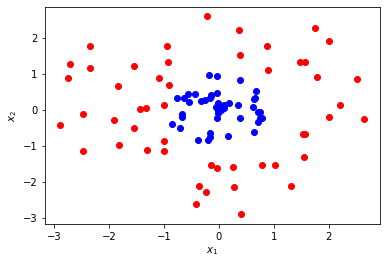

In [52]:
phi=-np.pi+2*np.pi*np.random.rand(100)
L=int(len(phi)/2)
r1=np.random.rand(L)
r2=1.0+2.0*np.random.rand(L)
T=np.zeros(2*L)
X=np.zeros((2*L,2))
for i in range(L):
  X[i,0]=r1[i]*np.cos(phi[i])
  X[i,1]=r1[i]*np.sin(phi[i])
  T[i]=1.0
  X[L+i,0]=r2[i]*np.cos(phi[L+i])
  X[L+i,1]=r2[i]*np.sin(phi[L+i])
plt.scatter(X[:L,0],X[:L,1],color='blue')
plt.scatter(X[L:,0],X[L:,1],color='red')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

Hagamos un cambio de variables "inteligente"

Text(0, 0.5, '$r$')

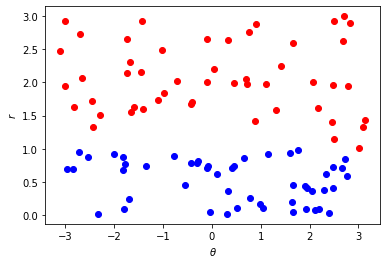

In [59]:
def phi(x):
  phi=np.zeros(2)
  if(x[0]!=0.0):
    phi[0]=np.arctan2(x[1],x[0])
  else:
    phi[0]=0.0
  phi[1]=np.sqrt(x[0]**2+x[1]**2)
  return phi

Y=np.zeros(X.shape)
for i,x in enumerate(X):
  Y[i]=phi(x)

plt.scatter(Y[:L,0],Y[:L,1],color='blue')
plt.scatter(Y[L:,0],Y[L:,1],color='red')
plt.xlabel(r'$\theta$')
plt.ylabel('$r$')

In [54]:
model = LogisticRegression()
model.fit(Y,T)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

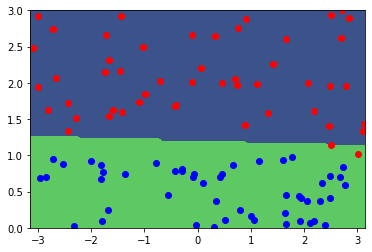

In [61]:
x=np.linspace(-np.pi,np.pi,100)
y=np.linspace(0,3.0,100)
Xtoplot,Ytoplot=np.meshgrid(x,y)
plt.xlim((-np.pi,np.pi))
plt.ylim((0.0,3))
Z=model.predict(np.c_[Xtoplot.ravel(), Ytoplot.ravel()]).reshape(Xtoplot.shape)
plt.contourf(Xtoplot,Ytoplot,Z,levels=[0.0,0.5,1.0])
plt.scatter(Y[:L,0],Y[:L,1],color='blue')
plt.scatter(Y[L:,0],Y[L:,1],color='red')
plt.xlabel(r'$\theta$')
plt.ylabel('$r$')

In [63]:
confusion_matrix(T, model.predict(Y))#[[tn, fp],[fp, tp]]

array([[48,  2],
       [ 0, 50]])

In [64]:
tn, fp, fn, tp = confusion_matrix(T, model.predict(X)).ravel()
recall= tp/(tp + fn)
precision = tp/(tp + fp)
fpr = fp/(fp + tn)
print(recall,precision,fpr)

1.0 0.5681818181818182 0.76


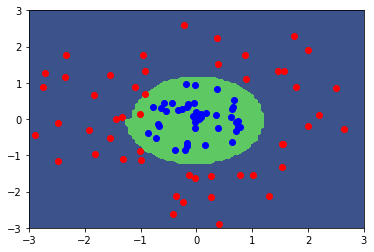

In [76]:
x=np.linspace(-3.0,3.0,100)
y=np.linspace(-3.0,3.0,100)
Xtoplot,Ytoplot=np.meshgrid(x,y)
plt.xlim((-3,3))
plt.ylim((-3.0,3.0))
yaux=np.asarray([phi(el) for el in np.c_[Xtoplot.ravel(), Ytoplot.ravel()]])
Z=model.predict(yaux).reshape(Xtoplot.shape)
plt.contourf(Xtoplot,Ytoplot,Z,levels=[0.0,0.5,1.0])
plt.scatter(X[:L,0],X[:L,1],color='blue')
plt.scatter(X[L:,0],X[L:,1],color='red')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')